In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

print(tf.__version__)

2.7.0


In [2]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
y_train = y_train.flatten()
y_test = y_test.flatten()

/home/park/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


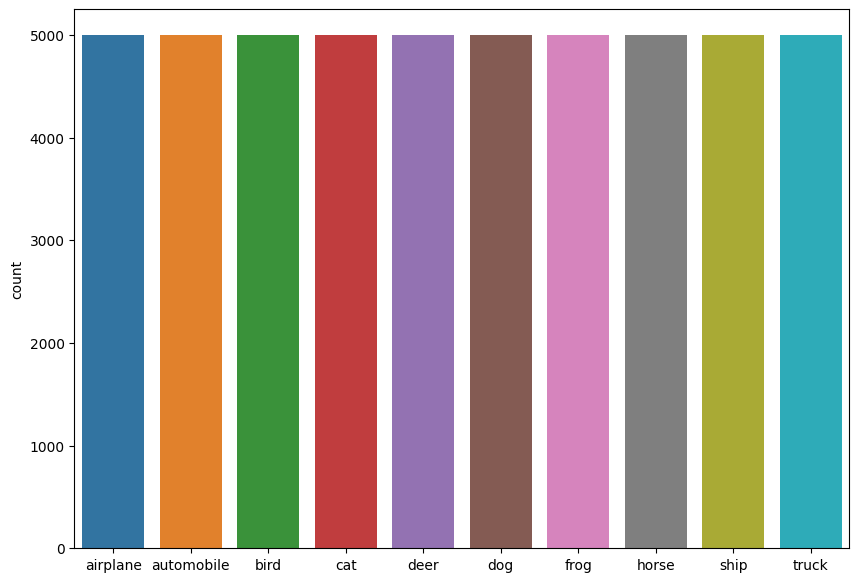

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,7))
p = sns.countplot(y_train)
p.set(xticklabels=classes)
plt.show()

In [5]:
np.isnan(x_train).any()

False

In [6]:
np.isnan(x_test).any()

False

In [7]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

In [8]:
print(x_train.shape)

(50000, 32, 32, 3)


In [9]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [10]:
y_train[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

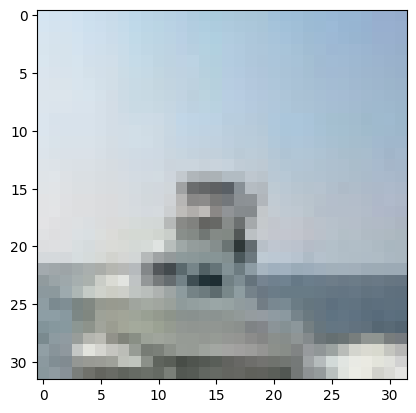

In [11]:
plt.imshow(x_train[100])
plt.show()

## Using tensorflow_datasets

In [12]:
import tensorflow_datasets as tfds

In [13]:
cifar_builder = tfds.builder("cifar10")
cifar_builder.download_and_prepare()

In [14]:
# Train/val Datasets:
train_dataset = cifar_builder.as_dataset(split=tfds.Split.TRAIN)
val_dataset = cifar_builder.as_dataset(split=tfds.Split.TEST)

# Number of classes:
num_classes = cifar_builder.info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_builder.info.splits['train'].num_examples
num_val_imgs = cifar_builder.info.splits['test'].num_examples

In [15]:
input_shape = [32, 32, 3]
               
batch_size = 32
               
num_epochs = 10

## Data augmentation

In [16]:
def _prepare_data_fn(features, input_shape, augment=False):
    
    input_shape = tf.convert_to_tensor(input_shape)
    
    image = features['image']
    label = features['label']
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32) # 데이터 타입 변환, normalize 진행
    
    if augment:
        # Randomly applied horizontal flip:
        image = tf.image.random_flip_left_right(image)
        
        # Random B/S changes:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check
        
        # Random resize and random crop back to expected size:
        random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
        scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
        scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, input_shape)
    else:
        image = tf.image.resize(image, input_shape[:2])
    return image, label

In [17]:
import functools

prepare_data_fn_for_train = functools.partial(_prepare_data_fn,
                                                input_shape=input_shape,
                                                augment=True)
prepare_data_fn_for_val = functools.partial(_prepare_data_fn,
                                            input_shape=input_shape,
                                            augment=False)

train_dataset = train_dataset.repeat(num_epochs) \
                        .shuffle(num_train_imgs) \
                        .map(prepare_data_fn_for_train, num_parallel_calls=4) \
                        .batch(batch_size) \
                        .prefetch(1)

val_dataset = val_dataset \
                    .repeat() \
                    .map(prepare_data_fn_for_val, num_parallel_calls=4) \
                    .batch(batch_size) \
                    .prefetch(1)

## Training Example

In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense

In [24]:
feature_extractor = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=input_shape,
)
# feature_extractor.trainable = False

In [25]:
x = feature_extractor.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=feature_extractor.input, outputs=output)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [26]:
optimizer = tf.keras.optimizers.Adam(0.001)

accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
                                                                
model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[accuracy_metric, top5_accuracy_metric])

In [27]:
import os

model_dir = './models/cifar-10'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics
    # stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_acc',
                                    restore_best_weights=True),
    
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}.h5')),
]

In [28]:
import math

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

history = model.fit(train_dataset,
                    epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                    validation_data=(val_dataset),
                    validation_steps=val_steps_per_epoch,
                    verbose=1, callbacks=callbacks)

Epoch 1/10
1563/1563 [==============================] - 42s 26ms/step - loss: 1.8895 - acc: 0.2435 - top5_acc: 0.8255 - val_loss: 1.6367 - val_acc: 0.3387 - val_top5_acc: 0.8938
Epoch 2/10
1563/1563 [==============================] - 40s 26ms/step - loss: 1.5298 - acc: 0.4049 - top5_acc: 0.9111 - val_loss: 1.3708 - val_acc: 0.4768 - val_top5_acc: 0.9323
Epoch 3/10
1563/1563 [==============================] - 40s 26ms/step - loss: 1.3303 - acc: 0.5135 - top5_acc: 0.9347 - val_loss: 1.2544 - val_acc: 0.5480 - val_top5_acc: 0.9467
Epoch 4/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.1588 - acc: 0.5861 - top5_acc: 0.9490 - val_loss: 1.1532 - val_acc: 0.6179 - val_top5_acc: 0.9575
Epoch 5/10
1563/1563 [==============================] - 40s 26ms/step - loss: 1.0422 - acc: 0.6339 - top5_acc: 0.9573 - val_loss: 0.9701 - val_acc: 0.6654 - val_top5_acc: 0.9644
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9605 - acc: 0.6668 - top5_acc:

1563/1563 [==============================] - 39s 25ms/step - loss: 0.7819 - acc: 0.7392 - top5_acc: 0.9714 - val_loss: 0.8081 - val_acc: 0.7419 - val_top5_acc: 0.9626
